In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext heat

ModuleNotFoundError: No module named 'heat'

In [3]:
import logging
import pandas as pd
import numpy as np

In [4]:
%%heat

import pandas as pd
import numpy as np
from abc import ABCMeta, abstractmethod
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count
from typing import Callable, Type, Dict
from rlbook.testbeds import Testbed
import warnings
from collections import namedtuple
import logging
from itertools import repeat
from copy import deepcopy
from math import sqrt, log


def init_constant(testbed, q_val=0):
    """Set initial action value estimate as a given constant, defaults to 0"""
    return {a: q_val for a in testbed.expected_values}

class Testbed(metaclass=ABCMeta):
    """Base Testbed class

    Attributes:
        expected_values (dict):
            Dict of parameters describing the Testbed distribution
    """

    def __init__(self, expected_values):
        self.initial_ev = expected_values
        self.expected_values = deepcopy(self.initial_ev)

    def estimate_distribution(self, n=1000) -> pd.DataFrame:
        """Provide an estimate of the testbed values across all arms
        n (int): Number of iterations to execute in testbed
        """
        self.p_drift = 0.0
        R = pd.DataFrame(columns=["reward", "action", "strategy"])
        for a in self.expected_values:
            Ra = pd.DataFrame(self.action_value(a, shape=(n, 1)), columns=["reward"])
            Ra["action"] = a
            Ra["strategy"] = "uniform"
            R = pd.concat([R, Ra])
        # Also include initial EV if pdrift shifted EVs
        if self.initial_ev != self.expected_values:
            self.expected_values = deepcopy(self.initial_ev)
            for a in self.initial_ev:
                Ra = pd.DataFrame(self.action_value(a, shape=(n, 1)), columns=["reward"])
                Ra["action"] = a
                Ra["strategy"] = "uniform"
                R = pd.concat([R, Ra])
        return R

    def reset_ev(self):
        self.expected_values = deepcopy(self.initial_ev)

    def best_action(self):
        """Return true best action that should have been taken based on EV state
        """

        A_best = list(self.expected_values.keys())[
            np.argmax([ev["mean"] for ev in self.expected_values.values()])
        ]
        return A_best

    @abstractmethod
    def action_value(self, action, shape=None) -> np.ndarray or float:
        """Return reward value given action"""
        pass


class NormalTestbed(Testbed):
    """Return random value from a Normal Distribution according to expected value config

    Attributes:
        expected_values (dict):
            Dict of means and variances describing Normal Distribution of each arm in the testbed
            Example:
                expected_values = {1: {'mean': 0.5, 'var': 1}, 2: {'mean': 1, 'var': 1}}
        p_drift (float):
            Probability for underlying reward to change ranging from 0.0 to 1.0, defaults to 0
        drift_mag (float):
            Magnitude of reward change when drifting, defaults to 1.0
    """

    def __init__(self, expected_values: Dict, p_drift=0.0, drift_mag=1.0):
        self.p_drift = p_drift
        self.drift_mag = drift_mag
        super().__init__(expected_values)

    def action_value(self, action, shape=None) -> np.ndarray or float:
        """Return reward value given action"""
        if np.random.binomial(1, self.p_drift) == 1:
            A_drift = list(self.expected_values.keys())[np.random.randint(len(self.expected_values))]
            self.expected_values[A_drift]["mean"] = self.expected_values[A_drift][
                "mean"
            ] + self.drift_mag * (np.random.random() - 0.5)

        return np.random.normal(
            loc=self.expected_values[action]["mean"],
            scale=self.expected_values[action]["var"],
            size=shape,
        )


class Bandit(metaclass=ABCMeta):
    """Base Bandit class

    Attributes:
        testbed (TestBed class object):
            Testbed object that returns a Reward value for a given Action
        columns (list of strings):
            List of numpy column names to use when outputting results
            as a pandas dataframe.
        action_values (numpy array):
            Stores results of the actions values method.
            Contains Run, Step, Action, and Reward
            Initialized as None, and created with the run method.
        n (int):
            Current step in a run
        Q_init (initialization function):
            Function to use for initializing Q values, defaults to zero init
        Q (dict):
            Action-value estimates in format {action: reward_estimate (float), ...}
        Na (dict):
            Count of how many times an action has been chosen
            {action X: action X count, ...}
        At (int):
            Action that corresponds to the index of the selected testbed arm
    """

    def __init__(self, Q_init: Dict):
        self.columns = [
            "run",
            "step",
            "action",
            "reward",
            "optimal_action",
        ]
        self.action_values = None
        self.n = 1
        self.Q_init = Q_init
        self.Q = deepcopy(Q_init)
        self.Na = {a: 0 for a in self.Q}
        self.At = self.argmax(self.Q)

    def initialization(self, testbed):
        """Reinitialize bandit for a new run when running in serial or parallel"""
        testbed.reset_ev()
        self.n = 1
        self.Q = deepcopy(self.Q_init)
        self.Na = {a: 0 for a in self.Q}
        self.At = self.argmax(self.Q)

    def argmax(self, Q):
        """Return max estimate Q, if tie between actions, choose at random between tied actions"""
        Q_array = np.array(list(self.Q.values()))
        At = np.argwhere(Q_array == np.max(Q_array)).flatten().tolist()

        if len(At) > 1:
            At = np.random.choice(At)
        else:
            At = At[0]

        return list(Q.keys())[At]

    @abstractmethod
    def select_action(self, testbed):
        """Select action logic"""
        pass

    def run(self, testbed, steps, n_runs=1, n_jobs=4, serial=False):
        """Run bandit for specified number of steps and optionally multiple runs"""

        if serial:
            self.action_values = self._serialrun(testbed, steps, n_runs)
        elif n_runs >= 4:
            if n_jobs > cpu_count():
                warnings.warn(
                    f"Warning: running n_jobs: {n_jobs}, with only {cpu_count()} cpu's detected",
                    RuntimeWarning,
                )
            self.action_values = self._multirun(testbed, steps, n_runs, n_jobs=n_jobs)
        else:
            self.action_values = self._serialrun(testbed, steps, n_runs)

    def _serialrun(self, testbed, steps, n_runs):
        action_values = np.empty((steps, len(self.columns), n_runs))
        for k in range(n_runs):
            action_values[:, 0, k] = k
            for n in range(steps):
                action_values[n, 1, k] = n
                action_values[n, 2:, k] = self.select_action(testbed)

            # Reset Q for next run
            self.initialization(testbed)

        return action_values

    def _singlerun(self, testbed, steps, idx_run):
        # Generate different random states for parallel workers
        np.random.seed()

        action_values = np.empty((steps, len(self.columns), 1))
        action_values[:, 0, 0] = idx_run
        for n in range(steps):
            action_values[n, 1, 0] = n
            action_values[n, 2:, 0] = self.select_action(testbed)

        # Reset Q for next run
        self.initialization(testbed)

        return action_values

    def _multirun(self, testbed, steps, n_runs, n_jobs=4):
        with ProcessPoolExecutor(max_workers=n_jobs) as executor:
            action_values = executor.map(
                self._singlerun,
                repeat(testbed, n_runs),
                [steps for n in range(n_runs)],
                list(range(n_runs)),
            )
        return np.squeeze(np.stack(list(action_values), axis=2))

    def output_df(self):
        """Reshape action_values numpy array and output as pandas dataframe"""
        n_rows = self.action_values.shape[2] * self.action_values.shape[0]
        df = pd.DataFrame(
            data=self.action_values.transpose(2, 0, 1).reshape(-1, len(self.columns)),
            columns=self.columns,
        )

        return df


class EpsilonGreedy(Bandit):
    """Epsilon greedy bandit
    Choose the 'greedy' option that maximizes reward but 'explore' a random action
    for a certain percentage of steps according to the epsilon value

    Attributes:
        epsilon (float):
            epsilon coefficient configuring the probability to explore non-optimal actions,
            ranging from 0.0 to 1.0
        alpha (float or "sample_average"):
            Constant step size ranging from 0.0 to 1.0, resulting in Q being the weighted average
            of past rewards and initial estimate of Q

            Note on varying step sizes such as using 1/n "sample_average":
                self.Q[self.At] = self.Q[self.At] + 1/self.Na[self.At]*(R-self.Q[self.At])
            Theoretically guaranteed to converge, however in practice, slow to converge compared to constant alpha
    """

    def __init__(self, Q_init: Dict, epsilon=0.1, alpha=0.1):
        super().__init__(Q_init)
        self.epsilon = epsilon
        self.alpha = alpha

    def select_action(self, testbed):
        if np.random.binomial(1, self.epsilon) == 1:
            self.At = list(self.Q.keys())[np.random.randint(len(self.Q))]
        else:
            self.At = self.argmax(self.Q)

        A_best = testbed.best_action()
        R = testbed.action_value(self.At)
        self.Na[self.At] += 1
        if self.alpha == "sample_average":
            self.Q[self.At] = self.Q[self.At] + 1 / self.Na[self.At] * (
                R - self.Q[self.At]
            )
        else:
            logging.debug(f"alpha: {self.alpha}, At: {self.At}, R: {R}")
            self.Q[self.At] = self.Q[self.At] + self.alpha * (R - self.Q[self.At])

        self.n += 1

        return (self.At, R, A_best)

    def output_df(self):
        """Reshape action_values numpy array and output as pandas dataframe
        Add epsilon coefficient used for greedy bandit
        """
        df = super().output_df()
        df["epsilon"] = self.epsilon

        return df

EXPECTED_VALUES = {
    1: {"mean": 2, "var": 1},
    2: {"mean": -1, "var": 1},
    3: {"mean": 1, "var": 1},
    4: {"mean": 0, "var": 1},
    5: {"mean": 1.7, "var": 1},
}

testbed = NormalTestbed(EXPECTED_VALUES)
testbed_drift = NormalTestbed(EXPECTED_VALUES, p_drift=0.0)

bandit = EpsilonGreedy(init_constant(testbed, q_val=10), epsilon=0)
bandit.run(testbed, 2000, n_runs=1)

UsageError: Cell magic `%%heat` not found.


In [5]:
def best_action(expected_values):
    """Return true best action that should have been taken based on EV state
    """

    A_best = list(expected_values.keys())[
        np.argmax([ev["mean"] for ev in expected_values.values()])
    ]
    return A_best

ev = {
    0: {"mean": 2, "var":1},
    1: {"mean": -1, "var":1},
    2: {"mean": 1, "var":1},
    3: {"mean": 0, "var":1},
    4: {"mean": 1.7, "var":1},
}

In [6]:
%%timeit
best_action(ev)

3.14 µs ± 57.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
def best_action_np(means):
    """Return true best action that should have been taken based on EV state
    """

    return np.argmax(means)

means = np.array([2, -1, 0, 1.7])

In [8]:
%%timeit

best_action_np(means)

975 ns ± 41.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [45]:
def argmax(Q):
        """Return max estimate Q, if tie between actions, choose at random between tied actions"""
        Q_array = np.array(list(Q.values()))
        At = np.argwhere(Q_array == np.max(Q_array)).flatten().tolist()

        if len(At) > 1:
            At = np.random.choice(At)
        else:
            At = At[0]

        return list(Q.keys())[At]


Q = {
    0:  2,
    1:  -1,
    2:  1, 
    3:  0, 
    4: 1.7,
} 

In [46]:
%%timeit

argmax(Q)

11.5 µs ± 205 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [196]:
Q = np.array([2, -1, 1, 5, 1.7])

In [197]:
%%timeit

np.argmax(Q)

885 ns ± 49.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [192]:

Q_f = np.array([2, -1, 1, 0, 1.7], order="F")

In [193]:
%%timeit

np.argmax(Q_f)

863 ns ± 41.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [159]:
class Test():
    def __init__(self):
        self.Q = np.array([2, -1, 1, 0, 1.7])


tmp = Test()

In [160]:
%%timeit

np.argmax(tmp.Q)
 

888 ns ± 30.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [ ]:
for i in range(1000):
    if Q[action] > Q[prev_action]


In [20]:
%%timeit

for i in range(2000):
    np.random.normal(
                loc=1,
                scale=1,
                size=None,
            )

3.9 ms ± 301 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%%timeit

tmp = {
    0: list(np.random.normal(
            loc=1,
            scale=1,
            size=2000,
                )
            ),
    1: list(np.random.normal(
            loc=1,
            scale=1,
            size=2000,
                )
            ),
}

for i in range(2000):
    tmp[0].pop()

347 µs ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [155]:
%%timeit

tmp = {
    0: list(np.random.normal(
            loc=1,
            scale=1,
            size=2000,
                )
            ),
    1: list(np.random.normal(
            loc=1,
            scale=1,
            size=2000,
                )
            ),
}

tmp2 = {0: 0, 1:0}

for i in range(2000):
    tmp[0][tmp2[0]]
    tmp2[0]+=1

417 µs ± 8.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [39]:
class Test():
    def __init__(self):
        self.tmp3 = 3

tmp1 = "TEST"
tmp2 = 100.0
tmp3 = Test()

In [40]:
%%timeit

for i in range(1000):
    logging.debug(f"tmp1: {tmp1}, tmp2: {tmp2}, tmp3: {tmp3.tmp3}")

785 µs ± 39.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [43]:
%%timeit

for i in range(1000):
    logging.debug("tmp1: %s, tmp2: %s, tmp3: %s", tmp1, tmp2, tmp3.tmp3)

523 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [44]:
%%timeit

for i in range(1000):
    if logging.getLogger().isEnabledFor(logging.DEBUG):
        logging.debug("tmp1: %s, tmp2: %s, tmp3: %s", tmp1, tmp2, tmp3.tmp3)

230 µs ± 5.83 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [183]:
%%timeit
tmp = np.empty([100, 3])
for i in range(100):
    tmp[i, 1:] = (42, 42)

45.3 µs ± 3.16 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [184]:
%%timeit
tmp1 = []
tmp2 = []
tmp3 = []

for i in range(100):
    tmp1.append(42)
    tmp2.append(42)
    tmp3.append(42)
tmp = np.column_stack([tmp1, tmp2, tmp3])

30.9 µs ± 2.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [179]:
tmp1 = []
tmp2 = []
tmp3 = []

for i in range(100):
    tmp1.append(42)
    tmp2.append(42)
    tmp3.append(42)
tmp = np.vstack([tmp1, tmp2, tmp3])

tmp.shape

(3, 100)

/home/joe/.pyenv/versions/miniconda3-latest/envs/rlbook/lib/python3.8/site-packages/pyheat/pyheat.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_yticklabels(row_labels, minor=False)


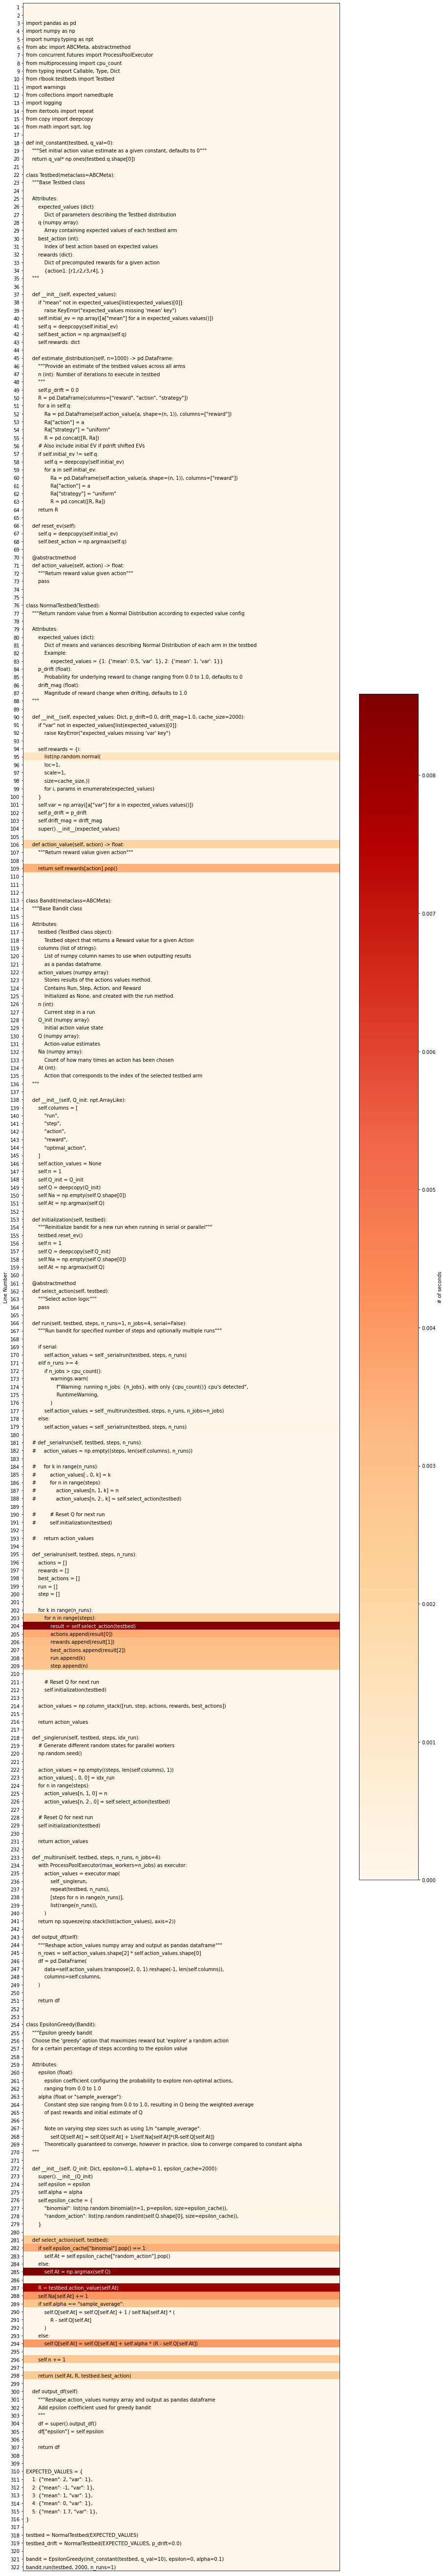

In [195]:
%%heat


import pandas as pd
import numpy as np
import numpy.typing as npt
from abc import ABCMeta, abstractmethod
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import cpu_count
from typing import Callable, Type, Dict
from rlbook.testbeds import Testbed
import warnings
from collections import namedtuple
import logging
from itertools import repeat
from copy import deepcopy
from math import sqrt, log

def init_constant(testbed, q_val=0):
    """Set initial action value estimate as a given constant, defaults to 0"""
    return q_val* np.ones(testbed.q.shape[0])

class Testbed(metaclass=ABCMeta):
    """Base Testbed class

    Attributes:
        expected_values (dict):
            Dict of parameters describing the Testbed distribution
        q (numpy array): 
            Array containing expected values of each testbed arm
        best_action (int):
            Index of best action based on expected values
        rewards (dict):
            Dict of precomputed rewards for a given action 
            {action1: [r1,r2,r3,r4], }
    """

    def __init__(self, expected_values):
        if "mean" not in expected_values[list(expected_values)[0]]:
            raise KeyError("expected_values missing 'mean' key")
        self.initial_ev = np.array([a["mean"] for a in expected_values.values()])
        self.q = deepcopy(self.initial_ev)
        self.best_action = np.argmax(self.q)
        self.rewards: dict

    def estimate_distribution(self, n=1000) -> pd.DataFrame:
        """Provide an estimate of the testbed values across all arms
        n (int): Number of iterations to execute in testbed
        """
        self.p_drift = 0.0
        R = pd.DataFrame(columns=["reward", "action", "strategy"])
        for a in self.q:
            Ra = pd.DataFrame(self.action_value(a, shape=(n, 1)), columns=["reward"])
            Ra["action"] = a
            Ra["strategy"] = "uniform"
            R = pd.concat([R, Ra])
        # Also include initial EV if pdrift shifted EVs
        if self.initial_ev != self.q:
            self.q = deepcopy(self.initial_ev)
            for a in self.initial_ev:
                Ra = pd.DataFrame(self.action_value(a, shape=(n, 1)), columns=["reward"])
                Ra["action"] = a
                Ra["strategy"] = "uniform"
                R = pd.concat([R, Ra])
        return R

    def reset_ev(self):
        self.q = deepcopy(self.initial_ev)
        self.best_action = np.argmax(self.q)

    @abstractmethod
    def action_value(self, action) -> float:
        """Return reward value given action"""
        pass


class NormalTestbed(Testbed):
    """Return random value from a Normal Distribution according to expected value config

    Attributes:
        expected_values (dict):
            Dict of means and variances describing Normal Distribution of each arm in the testbed
            Example:
                expected_values = {1: {'mean': 0.5, 'var': 1}, 2: {'mean': 1, 'var': 1}}
        p_drift (float):
            Probability for underlying reward to change ranging from 0.0 to 1.0, defaults to 0
        drift_mag (float):
            Magnitude of reward change when drifting, defaults to 1.0
    """

    def __init__(self, expected_values: Dict, p_drift=0.0, drift_mag=1.0, cache_size=2000):
        if "var" not in expected_values[list(expected_values)[0]]:
            raise KeyError("expected_values missing 'var' key")

        self.rewards = {i:
            list(np.random.normal(
            loc=1,
            scale=1,
            size=cache_size,))
            for i, params in enumerate(expected_values)
        }
        self.var = np.array([a["var"] for a in expected_values.values()])
        self.p_drift = p_drift
        self.drift_mag = drift_mag
        super().__init__(expected_values)

    def action_value(self, action) -> float:
        """Return reward value given action"""

        return self.rewards[action].pop()



class Bandit(metaclass=ABCMeta):
    """Base Bandit class

    Attributes:
        testbed (TestBed class object):
            Testbed object that returns a Reward value for a given Action
        columns (list of strings):
            List of numpy column names to use when outputting results
            as a pandas dataframe.
        action_values (numpy array):
            Stores results of the actions values method.
            Contains Run, Step, Action, and Reward
            Initialized as None, and created with the run method.
        n (int):
            Current step in a run
        Q_init (numpy array):
            Initial action value state
        Q (numpy array):
            Action-value estimates
        Na (numpy array):
            Count of how many times an action has been chosen
        At (int):
            Action that corresponds to the index of the selected testbed arm
    """

    def __init__(self, Q_init: npt.ArrayLike):
        self.columns = [
            "run",
            "step",
            "action",
            "reward",
            "optimal_action",
        ]
        self.action_values = None
        self.n = 1
        self.Q_init = Q_init
        self.Q = deepcopy(Q_init)
        self.Na = np.empty(self.Q.shape[0])
        self.At = np.argmax(self.Q)

    def initialization(self, testbed):
        """Reinitialize bandit for a new run when running in serial or parallel"""
        testbed.reset_ev()
        self.n = 1
        self.Q = deepcopy(self.Q_init)
        self.Na = np.empty(self.Q.shape[0])
        self.At = np.argmax(self.Q)

    @abstractmethod
    def select_action(self, testbed):
        """Select action logic"""
        pass

    def run(self, testbed, steps, n_runs=1, n_jobs=4, serial=False):
        """Run bandit for specified number of steps and optionally multiple runs"""

        if serial:
            self.action_values = self._serialrun(testbed, steps, n_runs)
        elif n_runs >= 4:
            if n_jobs > cpu_count():
                warnings.warn(
                    f"Warning: running n_jobs: {n_jobs}, with only {cpu_count()} cpu's detected",
                    RuntimeWarning,
                )
            self.action_values = self._multirun(testbed, steps, n_runs, n_jobs=n_jobs)
        else:
            self.action_values = self._serialrun(testbed, steps, n_runs)

    # def _serialrun(self, testbed, steps, n_runs):
    #     action_values = np.empty((steps, len(self.columns), n_runs))

    #     for k in range(n_runs):
    #         action_values[:, 0, k] = k
    #         for n in range(steps):
    #             action_values[n, 1, k] = n
    #             action_values[n, 2:, k] = self.select_action(testbed)

    #         # Reset Q for next run
    #         self.initialization(testbed)

    #     return action_values

    def _serialrun(self, testbed, steps, n_runs):
        actions = []
        rewards = []
        best_actions = []
        run = []
        step = []

        for k in range(n_runs):
            for n in range(steps):
                result = self.select_action(testbed)
                actions.append(result[0])
                rewards.append(result[1])
                best_actions.append(result[2])
                run.append(k)
                step.append(n)

            # Reset Q for next run
            self.initialization(testbed)
        
        action_values = np.column_stack([run, step, actions, rewards, best_actions])

        return action_values

    def _singlerun(self, testbed, steps, idx_run):
        # Generate different random states for parallel workers
        np.random.seed()

        action_values = np.empty((steps, len(self.columns), 1))
        action_values[:, 0, 0] = idx_run
        for n in range(steps):
            action_values[n, 1, 0] = n
            action_values[n, 2:, 0] = self.select_action(testbed)

        # Reset Q for next run
        self.initialization(testbed)

        return action_values

    def _multirun(self, testbed, steps, n_runs, n_jobs=4):
        with ProcessPoolExecutor(max_workers=n_jobs) as executor:
            action_values = executor.map(
                self._singlerun,
                repeat(testbed, n_runs),
                [steps for n in range(n_runs)],
                list(range(n_runs)),
            )
        return np.squeeze(np.stack(list(action_values), axis=2))

    def output_df(self):
        """Reshape action_values numpy array and output as pandas dataframe"""
        n_rows = self.action_values.shape[2] * self.action_values.shape[0]
        df = pd.DataFrame(
            data=self.action_values.transpose(2, 0, 1).reshape(-1, len(self.columns)),
            columns=self.columns,
        )

        return df


class EpsilonGreedy(Bandit):
    """Epsilon greedy bandit
    Choose the 'greedy' option that maximizes reward but 'explore' a random action
    for a certain percentage of steps according to the epsilon value

    Attributes:
        epsilon (float):
            epsilon coefficient configuring the probability to explore non-optimal actions,
            ranging from 0.0 to 1.0
        alpha (float or "sample_average"):
            Constant step size ranging from 0.0 to 1.0, resulting in Q being the weighted average
            of past rewards and initial estimate of Q

            Note on varying step sizes such as using 1/n "sample_average":
                self.Q[self.At] = self.Q[self.At] + 1/self.Na[self.At]*(R-self.Q[self.At])
            Theoretically guaranteed to converge, however in practice, slow to converge compared to constant alpha
    """
 
    def __init__(self, Q_init: Dict, epsilon=0.1, alpha=0.1, epsilon_cache=2000):
        super().__init__(Q_init)
        self.epsilon = epsilon
        self.alpha = alpha
        self.epsilon_cache = {
            "binomial": list(np.random.binomial(n=1, p=epsilon, size=epsilon_cache)),
            "random_action": list(np.random.randint(self.Q.shape[0], size=epsilon_cache)),
        }

    def select_action(self, testbed):
        if self.epsilon_cache["binomial"].pop() == 1:
            self.At = self.epsilon_cache["random_action"].pop() 
        else:
            self.At = np.argmax(self.Q)

        R = testbed.action_value(self.At)
        self.Na[self.At] += 1
        if self.alpha == "sample_average":
            self.Q[self.At] = self.Q[self.At] + 1 / self.Na[self.At] * (
                R - self.Q[self.At]
            )
        else:
            self.Q[self.At] = self.Q[self.At] + self.alpha * (R - self.Q[self.At])

        self.n += 1

        return (self.At, R, testbed.best_action)

    def output_df(self):
        """Reshape action_values numpy array and output as pandas dataframe
        Add epsilon coefficient used for greedy bandit
        """
        df = super().output_df()
        df["epsilon"] = self.epsilon

        return df


EXPECTED_VALUES = {
    1: {"mean": 2, "var": 1},
    2: {"mean": -1, "var": 1},
    3: {"mean": 1, "var": 1},
    4: {"mean": 0, "var": 1},
    5: {"mean": 1.7, "var": 1},
}

testbed = NormalTestbed(EXPECTED_VALUES)
testbed_drift = NormalTestbed(EXPECTED_VALUES, p_drift=0.0)

bandit = EpsilonGreedy(init_constant(testbed, q_val=10), epsilon=0, alpha=0.1)
bandit.run(testbed, 2000, n_runs=1)

In [142]:
np.random.binomial(1, 0.5, 10)

array([1, 0, 0, 1, 0, 1, 1, 1, 1, 1])

In [145]:
np.random.randint(5, size=5)

array([0, 2, 0, 1, 4])

In [ ]:
  self.rewards = {i:
            list(np.random.normal(
            loc=params,
            scale=1,
            size=cache_size,))
            for i, params in enumerate(expected_values)
        }